# Spatial Correlations within Biomes

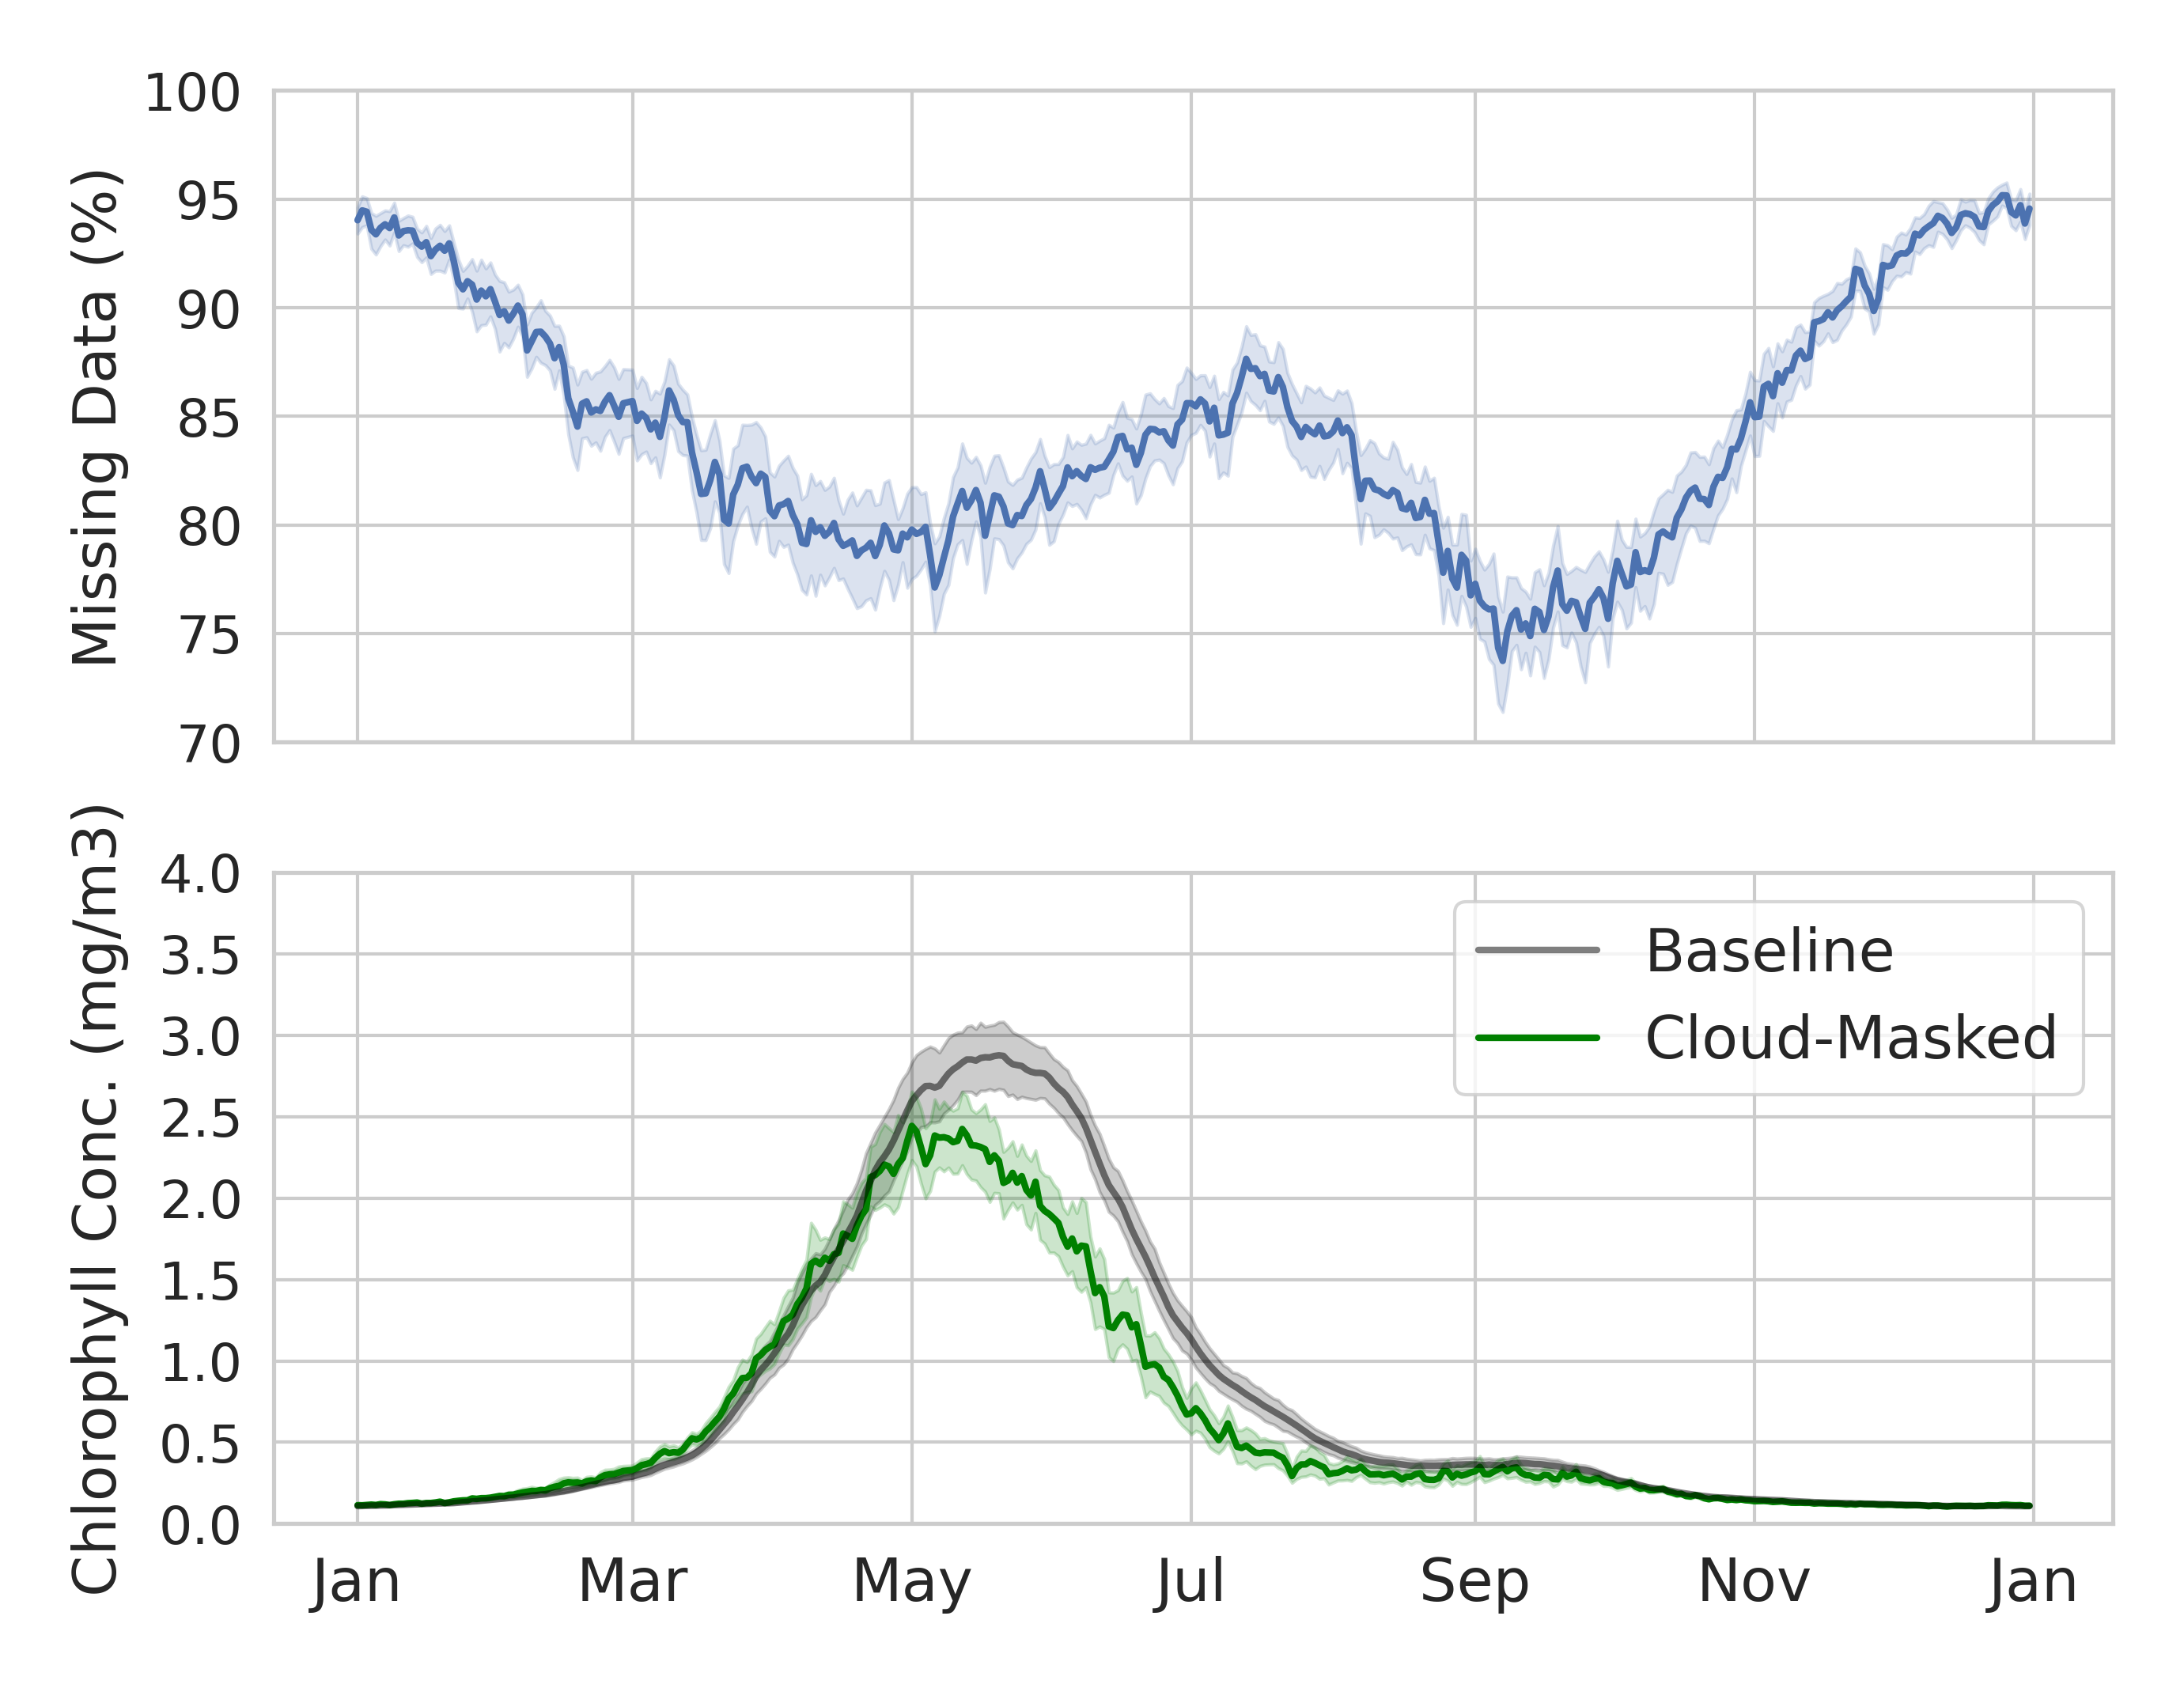

In [1]:
from IPython.display import Image
Image(filename='../plots/seasonal_cycles/north_pacific_seasonal_cycle.png') 

# **Can the differences in Baseline and Cloud-Masked chlorophyll within a biome be explained by the spatial correlattion between chl and clouds?**

In [27]:
import xarray as xr
import numpy as np
import pandas as pd
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib.colors import TwoSlopeNorm
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
from scipy import stats
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [11]:
from importlib.machinery import SourceFileLoader
plotting = SourceFileLoader("plotting", "../../plotting.py").load_module()

In [12]:
import os
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

USER = os.environ['USER']

In [13]:
cluster = PBSCluster(
    cores=1,
    memory='25GB', #25
    processes=1,
    queue='casper',
    local_directory=f'/glade/scratch/{USER}/dask-workers',
    log_directory=f'/glade/scratch/{USER}/dask-workers',
    resource_spec='select=1:ncpus=1:mem=25GB',
    project='P93300070',
    walltime='02:00:00',
    interface='ib0')

client = Client(cluster)
cluster.scale(15) # use when running climatology calculations
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:35853,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Import Data

In [14]:
TAREA = xr.open_dataset('/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.nday1.0001-01-01.nc').TAREA
biomes = xr.open_dataset('../data/biomes_regrid_pop.nc')

In [15]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/daily/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.ecosys.nday1.'
data = xr.open_mfdataset(base+'*.nc', concat_dim="time", parallel = True, chunks = {'time':365},
                              data_vars='minimal', compat='override', 
                              coords='minimal')
data

<xarray.Dataset>
Dimensions:                     (time: 10950, nlat: 384, nlon: 320)
Coordinates:
  * time                        (time) object 0020-01-01 00:00:00 ... 0049-12...
    ULONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables: (12/14)
    totChl                      (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_sat_nocld            (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_sat_nocld_wgt        (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_isccp_wgt            (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_isccp                (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis                (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    ...                          ...
    totChl_sat_nocld_wgt_swath  (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis_swath          (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis_wgt_swath      (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_modis             (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_isccp             (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_wgt               (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>

In [16]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/atm/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.cam.h1.'

cloud_data = xr.open_mfdataset(base+'*.nc', concat_dim="time", parallel = True, chunks={'time': 365}, 
                              data_vars='minimal', compat='override', 
                              coords='minimal')

cloud_data = cloud_data.sel(time=slice('0020-01-01','0049-12-31'))

# Cloud/Chlor Spatial Correlation per biome

For each month of the year, calculate the correlation between clouds and chlorophyll in each biome

This is useful for explaining the seasonal cycle plots. For example, in the North Pacific, regions of high chl also correpsond with regions of high cloud cover. So when we look at the seasonal cycle plots, the mean cloudy chlor is lower because statistically we are more likely to see the chlorophyll that is in the low-cloud region. 

### Monthly Correlations (in space)

In [17]:
# Take the monthly means
baseline_monthly = ((data.totChl_sat_nocld.groupby('time.month').sum(dim='time'))/(data.totChl_sat_nocld_wgt.groupby('time.month').sum(dim='time'))).compute()
baseline_monthly = np.log(baseline_monthly)
clouds_isccp_monthly = ((data.cloudfrac_isccp.groupby('time.month').sum(dim='time'))/(data.cloudfrac_wgt.groupby('time.month').sum(dim='time'))).compute()

In [118]:
#biome_means_df = pd.read_csv('biome_spatial_corr.csv')
biome_means_df = pd.DataFrame()

for biome in range(1,18):
    # if biome in biome_means_df['biome'].unique():
    #     continue
    print(biome)
    mask = (biomes.MeanBiomes==biome)
    
    for month in range(1,13):
        
        clouds = clouds_isccp_monthly.sel(month=month).where(mask)
        chlor = baseline_monthly.sel(month=month).where(mask)
        
        stacked = np.column_stack((chlor.to_numpy().flatten(), clouds.to_numpy().flatten()))
        stacked = stacked[~np.isnan(stacked).any(axis=1)]
        
        if stacked.shape[0] < 10:
            corr = np.nan
            p_val = np.nan
        
        else: 
            corr, p_val = stats.pearsonr(stacked[:,0], stacked[:,1])
            
        mean_chlor = chlor.weighted(TAREA).mean().compute()
        mean_clouds = clouds.weighted(TAREA).mean().compute()
        
        df_new = pd.DataFrame(data = {'biome': [biome], 'month': [month], 
                                      'log_baseline_chlor_mean': [mean_chlor.item()], 
                                      'isccp_clouds_mean': [mean_clouds.item()], 
                                      'spatial_corr': [corr], 'p_val': [p_val]})

        biome_means_df = pd.concat([biome_means_df, df_new])
        biome_means_df.to_csv('../data/biome_spatial_corr_pearson.csv')
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [119]:
biome_corr = pd.read_csv('../data/biome_spatial_corr_pearson.csv')
biome_corr = biome_corr.iloc[:,1:]
biome_corr = biome_corr.rename(columns = {'baseline_chlor_mean':'log_baseline_chlor_mean'})

## Create Correlation Matrix Plot

In [121]:
biome_corr_matrix = biome_corr[['spatial_corr', 'biome', 'month']]
biome_corr_matrix = pd.pivot(biome_corr_matrix, index='biome', columns='month', values='spatial_corr')
biome_corr_matrix = biome_corr_matrix.round(2)

In [122]:
pval_matrix = biome_corr[['p_val', 'biome', 'month']]
pval_matrix = pd.pivot(pval_matrix, index='biome', columns='month', values='p_val')

In [134]:
pval_mask = (pval_matrix>0.05)
strong_corr_mask = (abs(biome_corr_matrix)<0.5)

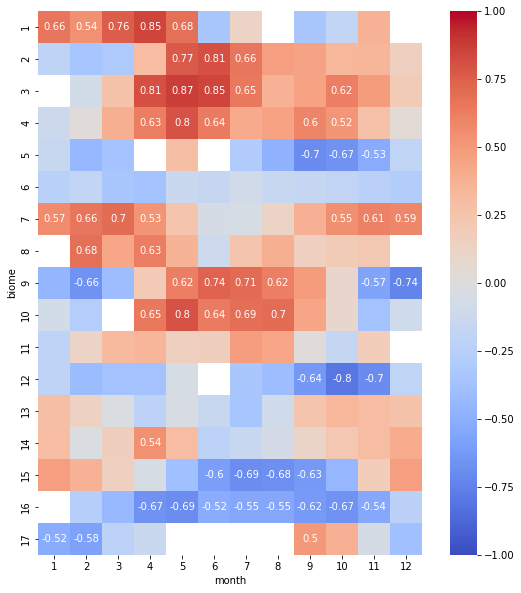

In [136]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    biome_corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True, annot=False, 
    mask=pval_mask
)

ax = sns.heatmap(
    biome_corr_matrix, cbar = False,
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm', alpha = 0,
    square=True, annot=True, 
    annot_kws = {'color':'white'},
    mask=strong_corr_mask
)

In [137]:
cluster.close()
client.close()